# Plateforme Agnostique de Traitement et d'Analyse des Textes
### Carnet d'expérimentation
---

## Sujet : Explainability


---

# Initialisations
---

In [1]:
_rs = 42

In [2]:
cd ../..

/Volumes/Geek/Work/Patat


In [3]:
import ast
import importlib
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

# Préparation Données

---

## Chargement

In [4]:
import patat.util.file

filename = 'data/prod/230517-OIDS-Label.pickle'

df_label = patat.util.file.pickle_load(filename)

In [48]:
df_label.columns

Index(['index', 'url', 'site', 'title', 'article', 'tags', 'paragraphs',
       'date_iso', 'abstract', 'Auteur', 'author', 'date', 'infox',
       'justification infox', 'entites_nommees', 'ouverture_esprit', 'faits',
       'opinions', 'propos_raportes', 'sources_citees', 'fausse_nouvelle',
       'insinuations', 'exageration', 'inverifiable', 'titre_decale',
       'cherry_picking', 'remarque observatoire', 'signe',
       'entites_coherentes', 'qualite_ecriture', 'intention',
       'scientifique_sulfureux', 'trop_mots', 'trop_chiffres', 'sophisme',
       'inversion_preuve', 'denigrement', 'degre_infox', 'observateur',
       'source', 'p_count', 'text', 'c_count', 'p_size', 'url_h'],
      dtype='object')

In [53]:
labels = ['infox',
       'justification infox', 'entites_nommees', 'ouverture_esprit', 'faits',
       'opinions', 'propos_raportes', 'sources_citees', 'fausse_nouvelle',
       'insinuations', 'exageration', 'inverifiable', 'titre_decale',
       'signe',
       'entites_coherentes', 'qualite_ecriture', 'intention',
       'scientifique_sulfureux', 'trop_mots', 'trop_chiffres', 'sophisme',
       'inversion_preuve']

In [72]:
selected_labels = ['infox','opinions','exageration','insinuations']

In [73]:
stopwords = patat.util.file.pickle_load('data/tmp/stopwords.pickle')

## Labels ou textes Nuls

In [74]:
df_label['text'].isna().sum()

0

In [75]:
for label in selected_labels:
    print(f'{label} : {df_label[label].isna().sum()}')

infox : 0
opinions : 96
exageration : 348
insinuations : 98


## Données dupliquées

In [11]:
df_label.duplicated(subset='text').sum()

0

In [12]:
df_label.duplicated(subset='url').sum()

0

# Experience
---

## Equilibrage Dataset

<Axes: xlabel='infox', ylabel='count'>

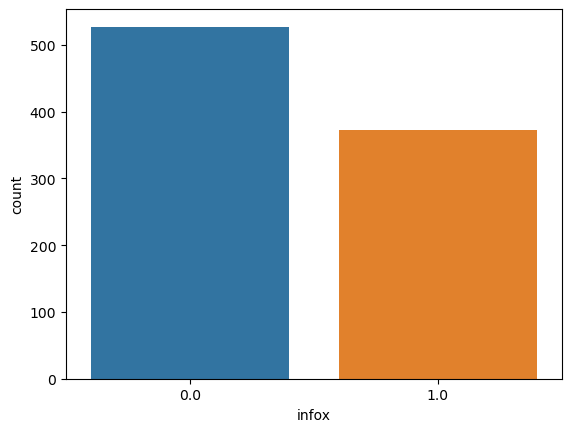

In [13]:
label_count = df_label['infox'].value_counts()
sns.barplot(x=label_count.index, y=label_count)

In [14]:
df_0 = df_label[df_label['infox'] == 0]
df_1 = df_label[df_label['infox'] == 1]

min_sample = min(len(df_0),len(df_1))


df_0=df_0.sample(min_sample,random_state=_rs)
df_1=df_1.sample(min_sample,random_state=_rs)
df_ml = pd.concat([df_0,df_1])[['text','infox']]

df_ml

,text,infox
609,Guerre en Ukraine: Emmanuel Macron prévient le...,0.0
705,La vaccination Covid : un marquage de « type b...,0.0
26,Colonialisme énergétique\nVisite d’État du pré...,0.0
565,De l’importance d’une Assemblée vraiment natio...,0.0
231,Quelle politique migratoire pour la France ? –...,0.0
...,...,...
112,Des scientifiques de Harvard et de Johns Hopki...,1.0
157,L’armée russe achète des exemplaires d’armemen...,1.0
522,ONU – Le Premier ministre de Nouvelle-Zélande ...,1.0
847,Pandémie ou le retour du grand Pan\nAu cours d...,1.0


In [15]:
print(df_ml['text'][15])

Selon le Pr Perronne l’apparition de la variole du singe n’est pas naturelle
La variole du singe est une maladie extrêmement rare et limitée à l’Afrique. Soudain, on nous annonce que des cas ont été enregistrés aux États-Unis, au Canada, au Royaume-Uni, en Australie, en Suède, aux Pays-Bas, en Belgique, en France, en Espagne, en Italie et en Allemagne, tous en même temps. Son nom est monkeypox ou variole du singe, et c’est la panique !
ttention à celui qui risque de faire perdre des milliards. Les milliards que les laboratoires encaissent grâce à l’interdiction des traitements contre le covid-19 et à l’obligation vaccinale pour avoir le droit de travailler et de se déplacer. Il a tenu « des propos considérés comme indignes de la fonction qu’il exerce ». Qui est ce pelé, ce galeux ? Le Pr Perronne, bien sûr !
Depuis que ses critiques sur la pseudo épidémie de covid ont été confirmées. Avec la variole du singe, le scénario catastrophe recommence et Perronne, ce complotiste invétéré, reco

In [76]:
df_ml = df_label

# Experience
---

## Expérience de cross validation pour mesurer la performance des modeles


`scores = cross_validate(classifier, X, y, cv=5, scoring = metriques)`

- `classifier` : Classifier
- `X` : Features
- `y` : Label cible
- `cv` : Nombre de cycle d'entrainement/test
- `scoring` : Métriques





In [77]:
cv=5
y = df_ml['infox']

## Tfidf 
Features : `X_tfidf`

In [78]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

In [79]:
def tokenizer(t):
    return re.findall(r'[^\W\d][^\W\d]+',t)

In [80]:
#vectorizer = TfidfVectorizer(stop_words=stopwords, token_pattern=r'[^\W\d][^\W\d]+')
vectorizer = TfidfVectorizer(stop_words=stopwords)

In [81]:
X_tfidf = vectorizer.fit_transform(df_ml['text'])

## SKLearn Logistic Regression

In [82]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [83]:
logreg = LogisticRegression(C=150, random_state=_rs, solver='lbfgs', multi_class='ovr', max_iter=1000)

In [84]:
#svd = TruncatedSVD(n_components=500, n_iter=7, random_state=42)
#X = svd.fit_transform(X_tfidf)
X = X_tfidf

In [ ]:
pd.set_option('display.precision',4)

In [102]:
df_results = []
for label in selected_labels:
    print(f'Processing : {label}')
    y = df_ml[label]
    y_label = y[y.notna()]
    X_label = X[y_label.index]
    scores = cross_validate(logreg, X_label, y_label, cv=cv,
                        scoring=('accuracy','f1','recall','roc_auc'))    
    df_scores=pd.DataFrame(scores)
    df_means = pd.DataFrame(df_scores.describe().loc['mean'],columns=[label])
    #df_results = df_results.append(df_means)
    print(df_scores)
pd.concat(df_results)

Processing : infox
   fit_time  score_time  test_accuracy  test_f1  test_recall  test_roc_auc
0    0.1656      0.0024         0.7278   0.6711       0.6757        0.8084
1    0.0919      0.0024         0.7722   0.6822       0.5946        0.8516
2    0.1616      0.0024         0.6611   0.5197       0.4400        0.7285
3    0.0935      0.0022         0.7722   0.6372       0.4800        0.8757
4    0.0843      0.0023         0.8056   0.7552       0.7200        0.9053
Processing : opinions
   fit_time  score_time  test_accuracy  test_f1  test_recall  test_roc_auc
0    0.1831      0.0024         0.6149   0.7075       0.8523        0.6345
1    0.1187      0.0022         0.6460   0.7273       0.8636        0.6935
2    0.1719      0.0023         0.6708   0.7166       0.7614        0.6865
3    0.0998      0.0022         0.6335   0.6811       0.7159        0.7176
4    0.1120      0.0023         0.6250   0.5833       0.4773        0.6496
Processing : exageration
   fit_time  score_time  test_accu

ValueError: No objects to concatenate

In [108]:
df_scores.describe().loc['mean']

fit_time         0.3050
score_time       0.0024
test_accuracy    0.6970
test_f1          0.3361
test_recall      0.2444
test_roc_auc     0.7249
Name: mean, dtype: float64

In [109]:
pd.DataFrame(df_scores.describe().loc['mean']).rename_axis(columns={'mean':})

,mean
fit_time,0.3050
score_time,0.0024
test_accuracy,0.6970
test_f1,0.3361
test_recall,0.2444
test_roc_auc,0.7249


In [86]:
df_scores=pd.DataFrame(scores)
#df_means = pd.DataFrame(df_scores.describe().loc[['mean','std']])
df_means = pd.DataFrame(df_scores.describe().loc['mean'])

pd.set_option('display.precision',4)
df_results = df_means
df_results

,mean
fit_time,0.1197
score_time,0.0024
test_accuracy,0.7478
test_f1,0.6531
test_recall,0.5821
test_roc_auc,0.8339


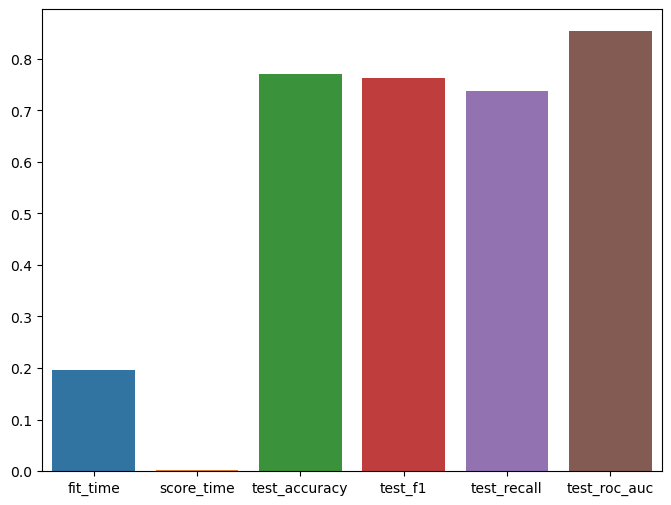

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.barplot(df_results.T)

<Figure size 800x600 with 0 Axes>

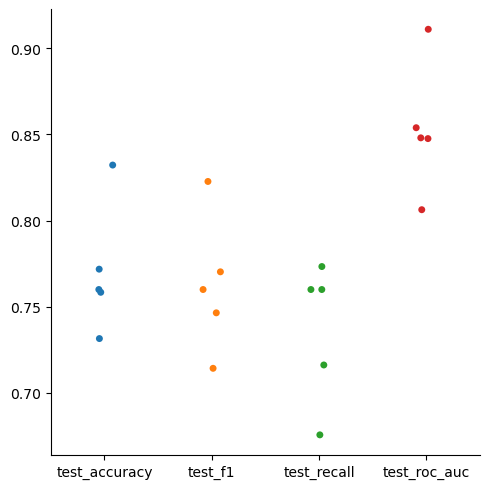

In [28]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.catplot(df_scores[['test_accuracy','test_f1','test_recall','test_roc_auc']])

### Pipeline

In [ ]:
from sklearn.pipeline import Pipeline

,text,infox
609,Guerre en Ukraine: Emmanuel Macron prévient le...,0.0
705,La vaccination Covid : un marquage de « type b...,0.0
26,Colonialisme énergétique\nVisite d’État du pré...,0.0
565,De l’importance d’une Assemblée vraiment natio...,0.0
231,Quelle politique migratoire pour la France ? –...,0.0
...,...,...
112,Des scientifiques de Harvard et de Johns Hopki...,1.0
157,L’armée russe achète des exemplaires d’armemen...,1.0
522,ONU – Le Premier ministre de Nouvelle-Zélande ...,1.0
847,Pandémie ou le retour du grand Pan\nAu cours d...,1.0


In [44]:
predictor_pipe = Pipeline(steps = [
    ('vectorizer',vectorizer), 
    ('classifier',logreg)
                  ])
predictor_pipe.fit(df_ml['text'], y)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['de', 'la', 'le', 'et', 'les',
                                             'des', 'en', 'un', 'est', 'que',
                                             'du', 'une', 'pour', 'qui', 'dans',
                                             'il', 'par', 'pas', 'sur', 'ce',
                                             'plus', 'au', 'qu', 'ont', 'ne',
                                             'sont', 'avec', 'été', 'se',
                                             'nous', ...])),
                ('classifier',
                 LogisticRegression(C=150, max_iter=1000, multi_class='ovr',
                                    random_state=42))])